## Machine Learning Explainability: Model-Agnostic Methods

*Prepared by:*  
**Jude Michael Teves**  
Faculty, Software Technology Department  
College of Computer Studies - De La Salle University

## Preliminaries

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import seaborn as sns

sns.set_style('darkgrid')

sns.set_palette('Set2')
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### Prepare Dataset

We will be using the Titanic dataset in this notebook.

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Cyntwikip/data-repository/main/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
from sklearn.impute import SimpleImputer

X = df.drop(['Survived','PassengerId','Name','Ticket','Cabin'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cols = X_train.columns
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = pd.DataFrame(imp_mean.transform(X_train), columns=cols)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns=cols)

print(f"Train Set Size | Input: {X_train.shape}, Output: {y_train.shape}")
print(f"Test Set Size | Input: {X_test.shape}, Output: {y_test.shape}")

Train Set Size | Input: (712, 8), Output: (712,)
Test Set Size | Input: (179, 8), Output: (179,)


## Global Model-Agnostic Methods

We can use model-agnostic methods for models that are not inherently interpretable.

### Permutation Importance

**What features have the biggest impact on predictions?**

Permutation importance is a method for measuring the impact of each feature on a model’s predictions. This is done by randomly shuffling one feature’s values and observing how much this disrupts the model’s performance.

This is an example of `sensitivity analysis`, which is a broader concept for evaluating how sensitive a model's output is to changes in the input. In my experience, the `sensitivity analysis` term is more often used in other fields.

#### Process

1. Train the model.
2. Shuffle a feature’s values and measure the drop in performance.
3. Restore the original feature values and repeat the process for other features.

The more a model’s performance drops after shuffling a feature, the more important that feature is.

In [137]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=True)
model.fit(X_train, y_train)
print(f"Score: {model.score(X_test, y_test):.2%}")

Score: 83.24%


#### Feature Importance

In [56]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
result_mean = pd.Series(result.importances_mean, index=cols).sort_values(ascending=False)
result_mean

Sex_male      0.174302
Pclass        0.070391
Fare          0.062011
Embarked_S    0.042458
Age           0.022346
Parch         0.015642
SibSp         0.011173
Embarked_Q    0.005587
dtype: float64

Text(0.5, 0, 'Decrease in accuracy score')

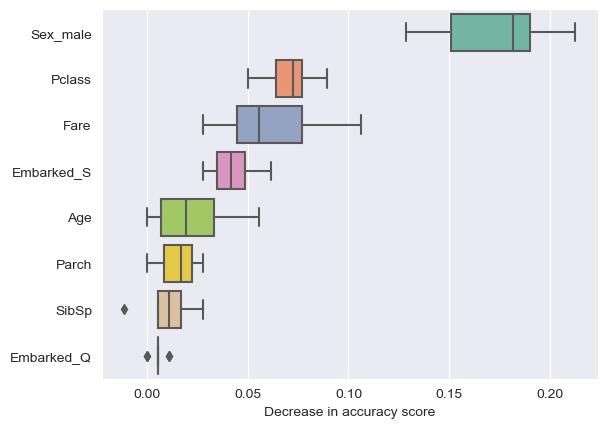

In [57]:
result_sorted = pd.DataFrame(result['importances'], index=cols).loc[result_mean.index,:]
sns.boxplot(result_sorted.T, orient='horizontal')
plt.xlabel('Decrease in accuracy score')

#### Interpreting Permutation Importances

The most important features appear at the top. The values reflect how much shuffling each feature affects the model’s performance. Negative values, if it happens, indicate that the shuffled data happened to give better results than the actual data—this often happens in small datasets due to chance.

### Partial Dependence Plots

Partial dependence plots visualize the relationship between a feature and the target, holding all other features constant. They help answer questions like: How does changing one feature, while keeping others the same, affect the prediction?

#### Process

1. Select Feature: Choose the feature of interest for analysis.
2. Create Value Grid: Generate a range of values for the selected feature. This is similar to hyperparameter tuning.
3. Make Predictions: Replace the feature's values in the dataset with the grid values and predict outcomes for each.
4. Average Predictions: Compute the average prediction for each grid value.
5. Visualize Results: Plot the average predictions (y-axis) against the feature values (x-axis) to create the PDP.
6. Interpret Trends: Analyze the plot to understand how the selected feature influences predictions.

#### Partial Plots using sklearn

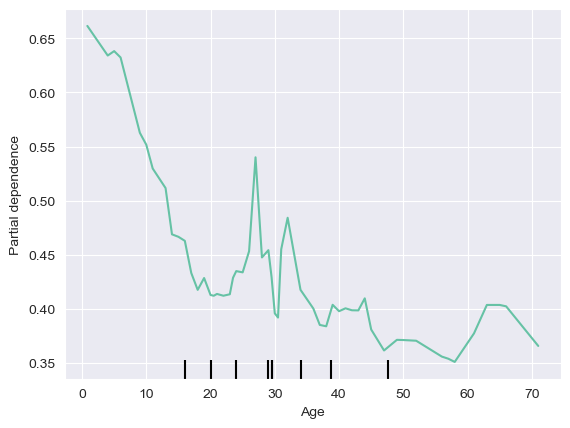

In [64]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
disp1 = PartialDependenceDisplay.from_estimator(model, X_test, ['Age'])
# disp1 = PartialDependenceDisplay.from_estimator(model, X_test, ['Sex_male'])
plt.show()

The graph shows the effect in the predictive power as we change the values in each feature. Generally, we can see that for this particular model, the performance worsens as the `Age` increases.

#### 2D Partial Plots

Similar to previous Partial dependence plot except we use 2 features instead of single feature.

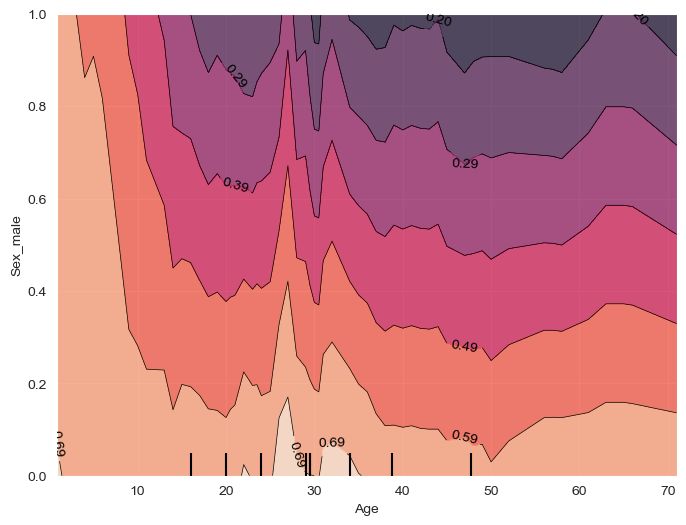

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Age', 'Sex_male')]

disp2 = PartialDependenceDisplay.from_estimator(model, X_test, f_names, ax=ax)
plt.show()

In the graph above, the lighter hue indicates better performance. We can see that if the passenger is `female` (not Sex_male) and the `Age` is lower, then we have the highest chances of survival.

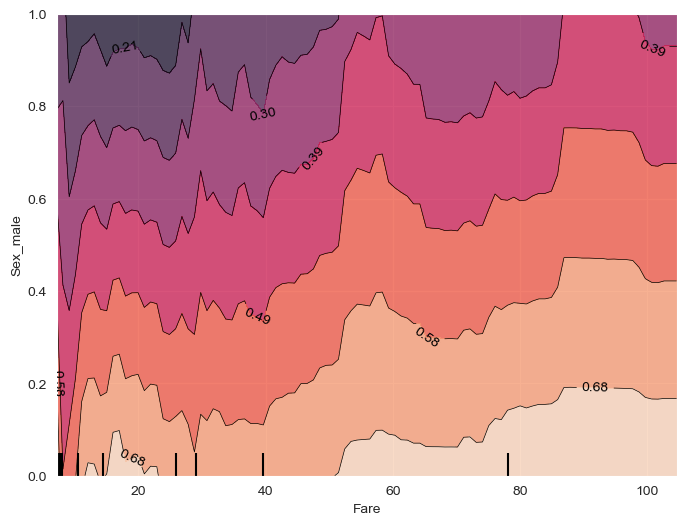

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Fare', 'Sex_male')]

disp3 = PartialDependenceDisplay.from_estimator(model, X_test, f_names, ax=ax)
plt.show()

Passengers that have higher `Fare` and are `female` have higher chances of survival.

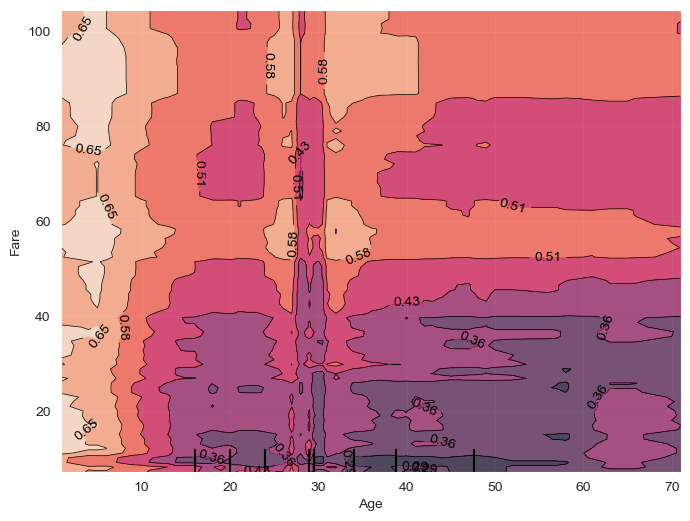

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Age', 'Fare')]

disp4 = PartialDependenceDisplay.from_estimator(model, X_test, f_names, ax=ax)
plt.show()

This graph is not as straightforward as the previous ones, but generally the passengers that have higher `Fare` and lower `Age` are likely to survive.

## Local Model-Agnostic Method

### SHAP

**What if you want to break down how the model works for an individual prediction?**

SHAP (SHapley Additive exPlanations) values provide local explanations for individual predictions by showing the contribution of each feature to a model’s output. Here is the command for installing SHAP:

`conda install -c conda-forge shap`  or  `pip install shap`

In [125]:
nrow = 5
X_test_sample = X_test.iloc[nrow]  # use 1 row of data here. Could use multiple rows if desired
X_test_sample_array = X_test_sample.values.reshape(1, -1)

print(f"Prediction: {model.predict_proba(X_test_sample_array)[0,1]:.2%}")

Prediction: 96.25%


/Users/judemichaelteves/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### Using SHAP

In [126]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_sample)
pd.Series(shap_values[:, 1], index=cols)

Pclass        0.134799
Age           0.031141
SibSp         0.021140
Parch         0.006790
Fare          0.097469
Sex_male      0.309875
Embarked_Q    0.000642
Embarked_S   -0.019089
dtype: float64

SHAP values break down each feature's contribution to the final prediction, offering granular insights into why a particular decision was made.

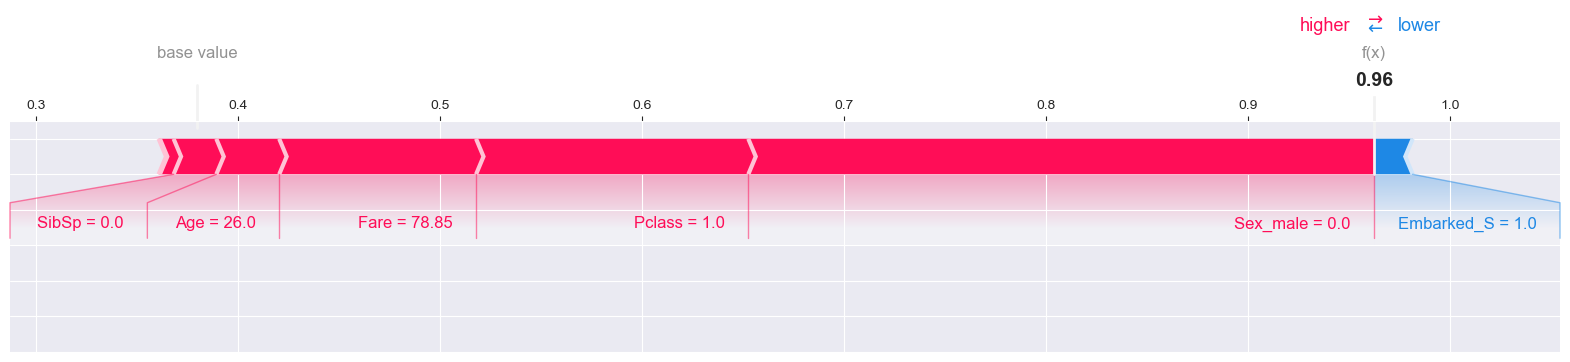

In [127]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:, 1], X_test_sample, matplotlib=True)

#### Interpreting SHAP

In [128]:
X_test.iloc[nrow].to_frame().T

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
5,1.0,26.0,0.0,0.0,78.85,0.0,0.0,1.0


Note that the specific data point being examined in the SHAP figure has characteristics shown in the cell above. 

The SHAP figure is showing that having `Sex_male = 0`, `Pclass = 1`, and `Fare = 78.85`, among other factors, are the main reasons why this data point is predicted to have a high rate of survival (`96%`).

#### Multiple data points

What if we want to get the SHAP values for multiple data points instead?

In [131]:
nrows = 20
X_test_sample = X_test.iloc[:nrows]  

explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_sample)
# pd.Series(shap_values[:, 1], index=cols)

shap.force_plot(explainer.expected_value[1], shap_values[:, :, 1], X_test_sample)

> Note! Dark mode users might not be able to see the graph properly. This is also an interactive graph so feel free to hover to see more details.

You can see that the graph is now showing the explanation for each of the data point in our sample. This might be tricky to visually inspect.


Another way to represent this is with a swarm plot. This is how to interpret it:

- The vertical position indicates which feature it represents.
- The color shows whether that feature's value is high or low for the given row in the dataset.
- The horizontal position shows whether that feature's value contributes to a higher or lower prediction.

In the figure, it shows that `male` passengers—represented by a high `Sex_male` value—tend to have lower prediction scores, whereas `female` passengers have higher scores. For `Fare`, the effect is generally reversed—lower fares tend to result in higher prediction scores, and vice versa.

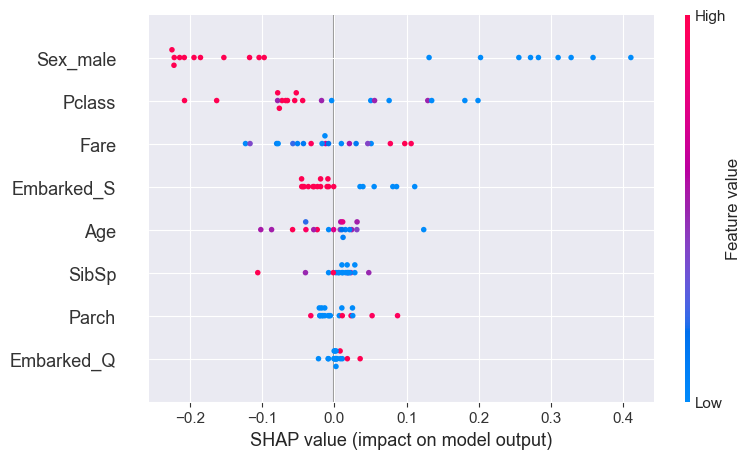

In [133]:
shap.summary_plot(shap_values[:,:,1], X_test_sample)  # Bar plot to show global feature importance
plt.show()

What if we simply get the average of the impact instead?

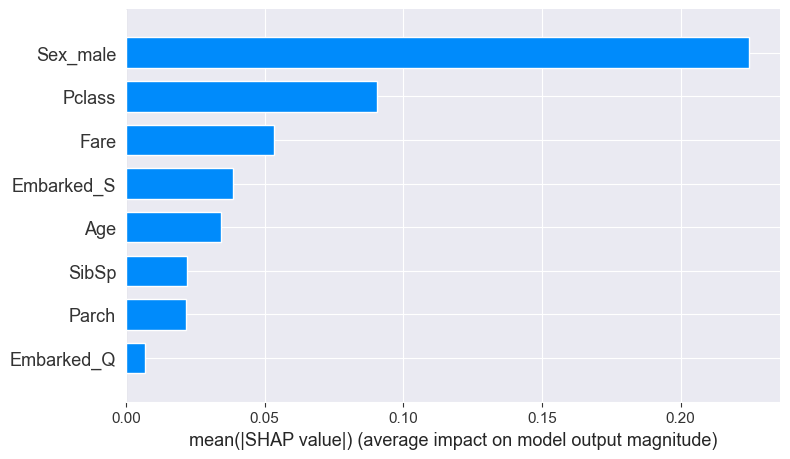

In [134]:
# Generate bar plot for global feature importance
shap.summary_plot(shap_values[:,:,1], X_test_sample, plot_type="bar")  # Bar plot to show global feature importance
plt.show()

#### KernelExplainer

Earlier, we used `shap.TreeExplainer(model)` since we used a tree-based model, but the SHAP package has explainers for other models. For instance, there's `shap.KernelExplainer`, which can be used with any model, though it tends to be slower and provides an approximation rather than exact SHAP values. The outputs aren't identical since it provides an approximation, but the overall insights remain the same. 

In [118]:
# use Kernel SHAP to explain test set predictions

k_explainer = shap.KernelExplainer(model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(X_test_sample)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[:, :, 1], X_test_sample)

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/20 [00:00<?, ?it/s]

> Note! Dark mode users might not be able to see the graph properly. This is also an interactive graph so feel free to hover to see more details.

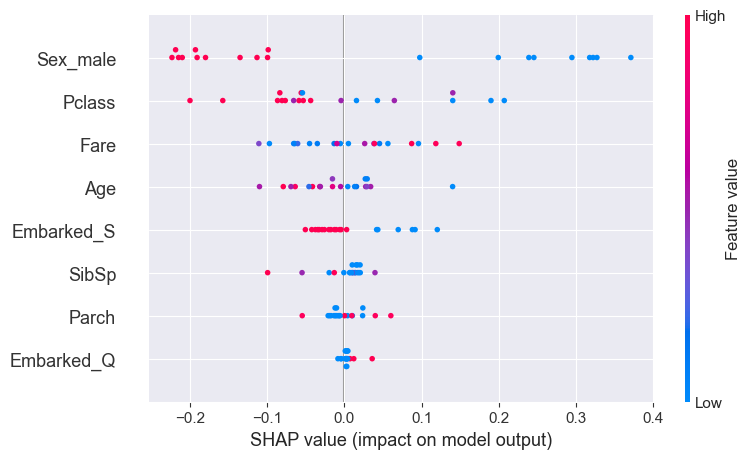

In [135]:
shap.summary_plot(k_shap_values[:,:,1], X_test_sample)  # Bar plot to show global feature importance
plt.show()

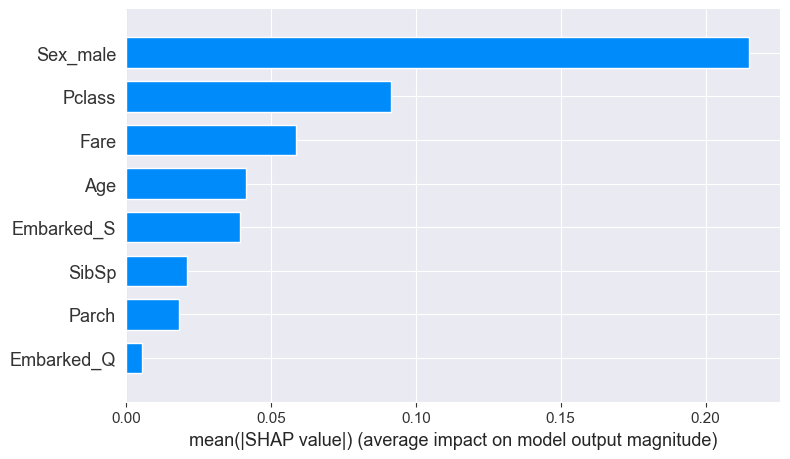

In [136]:
# Generate bar plot for global feature importance
shap.summary_plot(k_shap_values[:,:,1], X_test_sample, plot_type="bar")  # Bar plot to show global feature importance
plt.show()

## End
<sup>made by **Jude Michael Teves**</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> <href>judemichaelteves@gmail.com</href> or <href>jude.teves@dlsu.edu.ph</href></sup><br>
